Imports:

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt
import pyvista as pv
import pinns 
import datetime
import jax.scipy.optimize
import jax.flatten_util
import scipy
import scipy.optimize
import random

rnd_key = jax.random.PRNGKey(1234)
np.random.seed(14124)

2024-11-11 22:37:06.563545: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Set the default precision and the execution device.

In [2]:
jax.config.update("jax_enable_x64", False)
print("Devices: ", jax.devices())
dev = jax.devices('gpu')[0] if jax.device_count()>1 and len(jax.devices('gpu'))>0 else jax.devices('cpu')[0]
dev = jax.devices('gpu')[0]
print(dev)


Devices:  [CudaDevice(id=0)]
cuda:0


### Geometry definition 

Define the geometry patches:

In [3]:
def get_domain(r0: float, r1: float, R: float, h: float, H: float):

    angle = np.pi/4
    basis1 = pinns.functions.BSplineBasisJAX(np.array([-1, 0, 1]), 2)
    basis2 = pinns.functions.BSplineBasisJAX(np.array([-1, 1]), 2)
    basis3 = pinns.functions.BSplineBasisJAX(np.array([-1, 1]), 1)

    def tmp_gen(angle, r_0, r_1):
        pts = np.zeros([4, 3, 2, 3])
        weights = np.ones([4, 3, 2])

        a = np.pi/2-angle/2
        rs = np.linspace(r_0, r_1, 4)
        pts[-1, 0, 0, :] = [np.cos(-angle/2), np.sin(-angle/2), 0]
        pts[-1, 1, 0, :] = [1/np.sin(a), 0, 0]
        pts[-1, 2, 0, :] = [np.cos(angle/2), np.sin(angle/2), 0]
        pts[0, :, 0, :2] = rs[0] * pts[-1, :, 0, :2]
        pts[1, :, 0, :2] = rs[1] * pts[-1, :, 0, :2]
        pts[2, :, 0, :2] = rs[2] * pts[-1, :, 0, :2]
        pts[3, :, 0, :2] = rs[3] * pts[-1, :, 0, :2]
        pts[0, :, 0, 2] = -1
        pts[1, :, 0, 2] = -1
        pts[2, :, 0, 2] = -1
        pts[3, :, 0, 2] = -1
        pts[:, :, 1, :] = pts[:, :, 0, :]
        pts[:, :, 1, 2] = -pts[:, :, 1, 2]
        weights[:, 1, :] = np.sin(a)

        return pts, weights

    geoms = dict()

    pts, weights = tmp_gen(angle, r0, r1)
    pts[:, :, :, 2] *= h/2
    # pts[2:,:,:,2] *= h/2
    pts[3, 1, :, 0] = pts[3, 0, :, 0]
    pts[1, 1, :, 0] = 2*pts[0, 1, :, 0]/3+pts[-1, 1, :, 0]/3
    pts[2, 1, :, 0] = pts[0, 1, :, 0]/3+2*pts[-1, 1, :, 0]/3
    weights[-1, 1, :] = 1.0

    geoms['flat'] = pinns.geometry.PatchNURBS(
        [basis1, basis2, basis3], pts.copy(), weights.copy(), 0, 3)

    pts2 = pts[-1, :, :, :]
    weights[...] = 1.0
    linsp = np.linspace(0, 1, basis1.n)

    pts[0, :, :, :] = pts2
    pts[-1, :, :, :] = pts2
    pts[-1, :, :, 0] *= R/r1
    pts[-1, :, :, 1] *= H/h
    # pts[0, :, :, 2] *= H/h

    for i in range(1, basis1.n-1):
        pts[i, :, :, 2] = (1-linsp[i]**0.25)*pts[0, :, :, 2] + \
            linsp[i]**0.25*pts[-1, :, :, 2]
        pts[i, :, :, 0] = (1-linsp[i])*pts[0, :, :, 0] + \
            linsp[i]*pts[-1, :, :, 0]
        pts[i, :, :, 1] = (1-linsp[i]**4)*pts[0, :, :, 1] + \
            linsp[i]**4*pts[-1, :, :, 1]
        pts[i, :, :, 1] *= 2*(linsp[i]-1/2)**2+0.5
        pts[i, :, :, 2] *= 2*(linsp[i]-1/2)**2+0.5

    geoms['spoke'] = pinns.geometry.PatchNURBS(
        [basis1, basis2, basis3], pts, weights, 0, 3)

    pts, weights = tmp_gen((2*np.pi-angle)/3, r0, r1)
    pts[:, :, :, 2] *= h/2
    # pts[2:,:,:,2] *= h/2

    geoms['round_0'] = pinns.geometry.PatchNURBS(
        [basis1, basis2, basis3], pts, weights, 0, 3)
    geoms['round_0'].rotate((0, 0, angle/2 + (2*np.pi-angle)/3/2))

    pts, weights = tmp_gen((2*np.pi-angle)/3, r0, r1)
    pts[:, :, :, 2] *= h/2
    # pts[2:,:,:,2] *= h/2

    geoms['round_1'] = pinns.geometry.PatchNURBS(
        [basis1, basis2, basis3], pts, weights, 0, 3)
    geoms['round_1'].rotate((0, 0, np.pi))

    pts, weights = tmp_gen((2*np.pi-angle)/3, r0, r1)
    pts[:, :, :, 2] *= h/2
    # pts[2:,:,:,2] *= h/2

    geoms['round_2'] = pinns.geometry.PatchNURBS(
        [basis1, basis2, basis3], pts, weights, 0, 3)
    geoms['round_2'].rotate((0, 0, (2*np.pi-angle)/3 + np.pi))

    return geoms


geoms = get_domain(0.5, 0.8, 3.0, 1.0, 1.5)
names = list(geoms.keys())

Export as a VTK file for visualization in paraview.

In [4]:
with jax.disable_jit():
    objects = [pinns.extras.plot(geoms[n], dict(), N=32) for n in geoms]

obj = objects[0]
for i in range(1, len(objects)):
    obj = obj.merge(objects[i])

obj.save('testing.vtk')

Determine the connectivity of the patches:

In [5]:
with jax.disable_jit(True):
    connectivity = pinns.geometry.match_patches(geoms, eps=1e-4, verbose=False)

for c in connectivity:
    print(c)

{'first': 'flat', 'second': 'spoke', 'axis_first': (0,), 'axis_second': (0,), 'end_first': (-1,), 'end_second': (0,), 'axis_permutation': (None, (1, 1), (2, 1))}
{'first': 'flat', 'second': 'round_0', 'axis_first': (1,), 'axis_second': (1,), 'end_first': (-1,), 'end_second': (0,), 'axis_permutation': ((0, 1), None, (2, 1))}
{'first': 'flat', 'second': 'round_2', 'axis_first': (1,), 'axis_second': (1,), 'end_first': (0,), 'end_second': (-1,), 'axis_permutation': ((0, 1), None, (2, 1))}
{'first': 'spoke', 'second': 'round_0', 'axis_first': (0, 1), 'axis_second': (0, 1), 'end_first': (0, -1), 'end_second': (-1, 0), 'axis_permutation': (None, None, (2, 1))}
{'first': 'spoke', 'second': 'round_2', 'axis_first': (0, 1), 'axis_second': (0, 1), 'end_first': (0, 0), 'end_second': (-1, -1), 'axis_permutation': (None, None, (2, 1))}
{'first': 'round_0', 'second': 'round_1', 'axis_first': (1,), 'axis_second': (1,), 'end_first': (-1,), 'end_second': (0,), 'axis_permutation': ((0, 1), None, (2, 1))}

In [6]:
for k in geoms:
    pinns.geometry.save_patch('holder_'+k+'.geom', geoms[k])

import pickle 

with open('connectivity_holder.pkl', 'wb') as file: 
    pickle.dump(connectivity, file) 

### ANN spaces definition

The network is an MLP with residual connections and width set by the `nl` paraemter.
There are 2 spaces defined: first has 0 Dirichlet BCs on one facet and the other has no Dirichlet BCs enforced. 

In [7]:
n_layers = 16
acti =  stax.elementwise(lambda x: jax.nn.leaky_relu(x)**2)
w_init = jax.nn.initializers.normal()

#block_first = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl,W_init = w_init), acti, stax.Dense(nl,W_init = w_init), acti),stax.Dense(nl,W_init = w_init)),stax.FanInSum)
#block = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl,W_init = w_init), acti, stax.Dense(nl,W_init = w_init), acti),stax.Dense(nl,W_init = w_init)),stax.FanInSum)
block_first = lambda nl: stax.serial(stax.FanInConcat(),stax.Dense(nl, W_init = w_init,b_init=jax.nn.initializers.zeros),acti)
block = lambda nl: stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl,W_init = w_init), acti, stax.Dense(nl,W_init = w_init), acti),stax.Dense(nl,W_init = w_init)),stax.FanInSum)
        
nn_3d = stax.serial(block_first(n_layers), block(n_layers), block(n_layers), stax.Dense(3))
nn_2d = stax.serial(block_first(16), block(16), block(16), stax.Dense(3))
nn_1d = stax.serial(block_first(16), block(16), block(16), stax.Dense(3))

def monom(x, axis, zero, one, alpha=1.0):
    return ((x[...,axis]-zero)[...,None]/(one-zero))**alpha

### PINNs

Define the PINN class. The loss has to be defined. In this case, the nonlinear geometry is used.

In [8]:
class Pinn(pinns.PINN):
    
    def __init__(self):
          
        NP = 2
        input_shape = ((-1,3), (-1,NP))
        names_nn_2d = ["flat_spoke", "flat_round_0", "flat_round_2", "round_0_round_1", "round_1_round_2"]
        names_nn_1d = ["spoke_round_0_flat", "spoke_round_2_flat"]
        self.weights = {n: nn_3d[0](rnd_key, ((-1,3),(-1,NP)))[1] for n in names}
        self.weights.update({n: nn_2d[0](rnd_key, ((-1,2),(-1,NP)))[1] for n in names_nn_2d})
        self.weights.update({n: nn_1d[0](rnd_key, ((-1,1),(-1,NP)))[1] for n in names_nn_1d})
        #self.solutions = pinns.connectivity_to_interfaces({n: space_bc if 'spoke' in n else space for n in names}, connectivity, decay_fun=lambda x: x**2)
    
        self.solutions = {
            "spoke": lambda ws, x, p: nn_3d[1](ws["spoke"], (x, p))*monom(x, 0, -1, 1)*monom(x, 0, 1, -1)
                                    + nn_2d[1](ws["flat_spoke"], (x[...,1:3], p))*monom(x, 0, 1, -1)*monom(x, 1, 1, -1)*monom(x, 1, -1, 1)
                                    + nn_1d[1](ws["spoke_round_0_flat"], (x[...,2][...,None], p))*monom(x, 0, 1, -1)*monom(x, 1, -1, 1)
                                    + nn_1d[1](ws["spoke_round_2_flat"], (x[...,2][...,None], p))*monom(x, 0, 1, -1)*monom(x, 1, 1, -1),
                                    
            "flat": lambda ws, x, p: nn_3d[1](ws["flat"], (x, p))*monom(x, 0, 1, -1)*monom(x, 1, 1, -1)*monom(x, 1, -1, 1)
                                    + nn_2d[1](ws["flat_spoke"], (x[...,1:3], p))*monom(x, 0, -1, 1)*monom(x, 1, 1, -1)*monom(x, 1, -1, 1)
                                    + nn_2d[1](ws["flat_round_0"], (x[...,0:3:2], p))*monom(x, 0, 1, -1)*monom(x, 1, -1, 1)
                                    + nn_2d[1](ws["flat_round_2"], (x[...,0:3:2], p))*monom(x, 0, 1, -1)*monom(x, 1, 1, -1)
                                    + nn_1d[1](ws["spoke_round_0_flat"], (x[...,2][...,None], p))*monom(x, 0, -1, 1)*monom(x, 1, -1, 1)
                                    + nn_1d[1](ws["spoke_round_2_flat"], (x[...,2][...,None], p))*monom(x, 0, -1, 1)*monom(x, 1, 1, -1),
                                    
            "round_0": lambda ws, x, p: nn_3d[1](ws["round_0"], (x, p))*monom(x, 1, -1, 1)*monom(x, 1, 1, -1)
                                    + nn_2d[1](ws["round_0_round_1"], (x[...,0:3:2], p))*monom(x, 1, -1, 1)
                                    + nn_2d[1](ws["flat_round_0"], (x[...,0:3:2], p))*monom(x, 0, 1, -1)*monom(x, 1, 1, -1)
                                    + nn_1d[1](ws["spoke_round_0_flat"], (x[...,2][...,None], p))*monom(x, 0, -1, 1)*monom(x, 1, 1, -1),
                                    
            "round_1": lambda ws, x, p: nn_3d[1](ws["round_1"], (x, p))*monom(x, 1, -1, 1)*monom(x, 1, 1, -1)
                                    + nn_2d[1](ws["round_0_round_1"], (x[...,0:3:2], p))*monom(x, 1, 1, -1)
                                    + nn_2d[1](ws["round_1_round_2"], (x[...,0:3:2], p))*monom(x, 1, -1, 1),
                                    
            "round_2": lambda ws, x, p: nn_3d[1](ws["round_2"], (x, p))*monom(x, 1, -1, 1)*monom(x, 1, 1, -1)
                                    + nn_1d[1](ws["spoke_round_2_flat"], (x[...,2][...,None], p))*monom(x, 0, -1, 1)*monom(x, 1, -1, 1)
                                    + nn_2d[1](ws["round_1_round_2"], (x[...,0:3:2], p))*monom(x, 1, 1, -1)
                                    + nn_2d[1](ws["flat_round_2"], (x[...,0:3:2], p))*monom(x, 0, 1, -1)*monom(x, 1, -1, 1)
        }
        
        E = 0.02e5
        nu = 0.3
        self.E = E
        self.nu = nu
        
        self.lamda = E*nu/(1+nu)/(1-2*nu)
        self.mu = E/2/(1+nu)

        rho = 0.0
        g = 9.81
        self.rho = rho
        
        self.f = np.array([0,-g*rho,0]) 
        self.energy = lambda F,C,J,params: params[0]*jnp.sum(F**2, axis=(-2,-1)) + params[1]*jnp.abs(J)**2*jnp.sum(jnp.linalg.inv(F)**2, axis=(-1,-2)) + params[2]*J**2 - params[3]*jnp.log(jnp.abs(J))+params[4]
        self.energy = lambda F,C,J,params: 0.5*self.mu*(C[...,0,0]+C[...,1,1]+C[...,2,2]-3)-self.mu*jnp.log(jnp.abs(J))+0.5*self.lamda*jnp.log(jnp.abs(J))**2
        self.energy = lambda F,E,J,params: 0.5*self.lamda*(E[...,0,0]+E[...,1,1]+E[...,2,2])**2+self.mu*jnp.sum(E*E, axis=(-1,-2))
        #self.energy = lambda F,E,J,params: 0.5*self.lamda*(E[...,0,0]+E[...,1,1]+E[...,2,2])**2+self.mu*(E[...,0,0]**2+E[...,1,1]**2+E[...,2,2]**2)
        
        self.a = 0.5*self.mu
        self.b = 0.0
        self.c = 0.0
        self.d = self.mu
        self.e = -1.5*self.mu

        self.kpen = 8e3
        self.Ab = np.array([[0.0,1.0,0.0]]), np.array([[-0.75]]), np.array([[0.0,-1.0,0.0]]), np.array([[-0.75]])
        super(Pinn, self).__init__(geoms)
   
    def solution_flat(ws, x, p):
        
        return nn_3d[1](ws["flat"], (x, p))
 
    def loss(self, training_parameters, points, parameters):
        
        jacs = [pinns.functions.jacobian(lambda x, p: self.solutions[n](training_parameters, x, p))(points[n].points_reference, parameters) for n in names]
        jacs_x = [points[names[i]].jacobian_transformation(jacs[i]) for i in range(len(names))]
        Fs = [jnp.eye(3)+jacs_x[i] for i in range(len(names))]
        Cs = [jnp.einsum('mji,mki->mjk', Fs[i], Fs[i]) for i in range(len(names))]
        Cs = [0.5*(Cs[i]-jnp.eye(3)[None,...]) for i in range(len(names))]
        
        dets = [jnp.linalg.det(Fs[i]) for i in range(len(names))]
         
        Es = [jnp.dot(self.energy(Fs[i], Cs[i], dets[i], [self.a, self.b,self.c,self.d,self.e]), points[names[i]].dx()) for i in range(len(names))]
        rhss = [jnp.dot(dets[i] * jnp.einsum('k,mk->m', self.f, self.solutions[names[i]](training_parameters, points[names[i]].points_reference, parameters)), points[names[i]].dx()) for i in range(len(names))] 

        contact_res  = jnp.dot(pinns.geometry.gap_to_convex_polytope(self.Ab[0], self.Ab[1], jnp.einsum('i,j->ij', parameters[:,0]*0.1/2, np.array([0,1,0])) + points['ds2'].points_physical+self.solutions['round_2'](training_parameters, points['ds2'].points_reference, parameters))**2, points['ds2'].weights)
        contact_res += jnp.dot(pinns.geometry.gap_to_convex_polytope(self.Ab[2], self.Ab[3], jnp.einsum('i,j->ij', parameters[:,1]*0.1/2, np.array([0,-1,0])) + points['ds0'].points_physical+self.solutions['round_0'](training_parameters, points['ds0'].points_reference, parameters))**2, points['ds0'].weights)
        
        return sum(Es) - sum(rhss) + self.kpen * contact_res 
        
model = Pinn()  
weights = model.weights

### Training


In [9]:
opt_type = 'ADAM'

if opt_type == 'ADAM':
    
    
    n_batches = 100
    n_points = 4000000
    n_points_batch = n_points//n_batches
    
    lr_opti = optimizers.piecewise_constant([2000,3000,4000,5000,7000], [0.005, 0.005/2, 0.005/4, 0.005/8,0.005/16,0.005/32])
    lr_opti = optimizers.piecewise_constant([20,40,60, 80], [0.01, 0.01/2, 0.01/4,0.01/8,0.01/16])
    #lr_opti = optimizers.piecewise_constant([7000], [0.01/2, 0.001])
    #lr_opti = 0.01/2
    opt_init, opt_update, get_params = optimizers.adam(lr_opti)

    opt_state = opt_init(model.weights)
    weights_init = model.weights
    
    # get initial parameters
    params = get_params(opt_state)

    loss_grad = jax.jit(lambda ws, pts: (model.loss(ws, pts), jax.grad(model.loss)(ws, pts)), device = dev)

    def step(params, opt_state, key, step_no):
        # points = model.get_points_MC(5000)

        points = model.points_MonteCarlo(n_points_batch, key, [{'patch': 'round_2', 'label': 'ds2', 'axis': 0, 'end': -1, 'n': n_points_batch}, {'patch': 'round_0', 'label': 'ds0', 'axis': 0, 'end': -1, 'n': n_points_batch}])
        parameters_space = jax.random.uniform(key, (n_points_batch, 2))*2-1
        loss = model.loss(params, points, parameters_space)
        grads = jax.grad(model.loss)(params, points, parameters_space)
        #loss, grads = loss_grad(params, points)
        opt_state = opt_update(step_no, grads, opt_state)

        params = get_params(opt_state)
        
        return params, opt_state, loss

    step_compiled = jax.jit(step, device = dev)
    step_compiled(params, opt_state, rnd_key, 0)

    n_epochs = 100

    hist = []
    hist_weights = []
    
    # min_loss = 10000
    tme = datetime.datetime.now()
    for ep in range(n_epochs):
        losses = []
        for b in random.sample(range(n_batches), n_batches):
         
            params, opt_state, loss = step_compiled(params, opt_state, jax.random.PRNGKey(b+0*np.random.randint(100000)), ep)
        
            #print("\tbatch %d/%d"%(b+1, n_batches))
            hist.append(loss)
            losses.append(loss)
    
        hist_weights.append(params.copy())
        print('Epoch %d/%d - mean loss %e, max loss %e, min loss %e, std loss %e'%(ep+1, n_epochs, np.mean(losses), np.max(losses), np.min(losses), np.std(losses)))
        
    # update params
    model.weights = params
    weights = params
    tme = datetime.datetime.now() - tme
    print('Elapsed time ', tme)


Epoch 1/100 - mean loss 5.282067e+00, max loss 5.464190e+01, min loss 1.150193e+00, std loss 8.792472e+00
Epoch 2/100 - mean loss 8.919865e-01, max loss 1.145700e+00, min loss 7.655606e-01, std loss 9.466783e-02
Epoch 3/100 - mean loss 7.236087e-01, max loss 7.661083e-01, min loss 6.891446e-01, std loss 2.046204e-02
Epoch 4/100 - mean loss 6.664211e-01, max loss 6.952154e-01, min loss 6.399219e-01, std loss 1.429934e-02
Epoch 5/100 - mean loss 6.281891e-01, max loss 6.480744e-01, min loss 6.044011e-01, std loss 1.122389e-02
Epoch 6/100 - mean loss 5.972626e-01, max loss 6.128936e-01, min loss 5.803076e-01, std loss 7.621168e-03
Epoch 7/100 - mean loss 5.755146e-01, max loss 5.892974e-01, min loss 5.603656e-01, std loss 5.895291e-03
Epoch 8/100 - mean loss 5.623964e-01, max loss 5.741163e-01, min loss 5.485646e-01, std loss 5.472261e-03
Epoch 9/100 - mean loss 5.545377e-01, max loss 5.631948e-01, min loss 5.426826e-01, std loss 3.994962e-03
Epoch 10/100 - mean loss 5.498816e-01, max los

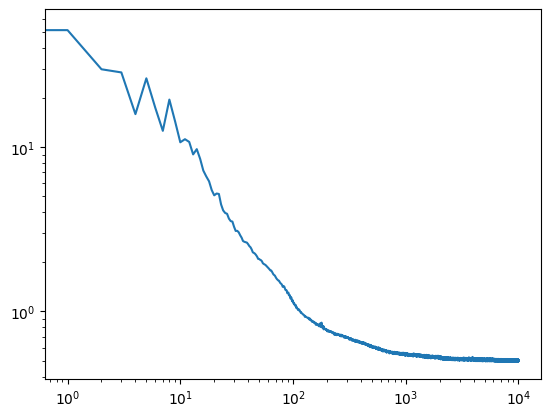

In [10]:
plt.loglog(hist)

### Plot 

Save the solution as a `.vtk` file.

In [11]:
def plot(p1, p2, fname):
    with jax.disable_jit():
        pv_objects = [pinns.extras.plot(geoms[n], {'displacement': lambda y: model.solutions[n](weights, y, np.zeros((y.shape[0], 2)) + np.array([p1, p2]))}, N= 25) for n in geoms]

    obj = pv_objects[0]
    for i in range(1,len(pv_objects)):
        obj = obj.merge(pv_objects[i])
    obj.save(fname)
    
plot(-1.0, -1.0, "solution_holder_contacts.0.vtk")
plot(-1.0, 1.0, "solution_holder_contacts.1.vtk")
plot(1.0, -1.0, "solution_holder_contacts.2.vtk")
plot(1.0, 1.0, "solution_holder_contacts.3.vtk")

In [12]:
#for ep in range(n_epochs):
#    with jax.disable_jit():
#        pv_objects = [pinns.extras.plot(geoms[n], {'displacement': lambda y: model.solutions[n](hist_weights[ep], y, np.zeros((y.shape[0], 2)))}, N= 25) for n in geoms]
#
#    obj = pv_objects[0]
#    for i in range(1,len(pv_objects)):
#        obj = obj.merge(pv_objects[i])
#    obj.save('solution_holder_contacts_%d.vtk'%(ep+1))

In [ ]:

plt = pv.Plotter()

p1 = 0.0
p2 = 0.0
def update_mesh(param, value):
    print(value)
    global p1, p2
    if param==0:
        p1 = value
    else:
        p2 = value
    pv_objects = [pinns.extras.plot(geoms[n], {'displacement': lambda y: model.solutions[n](hist_weights[ep], y, np.zeros((y.shape[0], 2))+[p1,p2])}, N= 25) for n in geoms]
    obj = pv_objects[0]
    for i in range(1,len(pv_objects)):
        obj = obj.merge(pv_objects[i])
        
    plt.add_mesh(pv_objects)

    return


plt.add_slider_widget(lambda v: update_mesh(0, v), [-1, 1], title='Param 1')
plt.add_slider_widget(lambda v: update_mesh(1, v), [-1, 1], title='Param 2')
plt.show()

0.0
